In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from warnings import filterwarnings
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
x_train = []
y_train = []
image_size = 256

folderPath = os.path.join('drive/MyDrive/x-ray/normal')
for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train.append(img)
    y_train.append(0)

folderPath = os.path.join('drive/MyDrive/x-ray/bad')
for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train.append(img)
    y_train.append(1)


x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=127)

Train Set


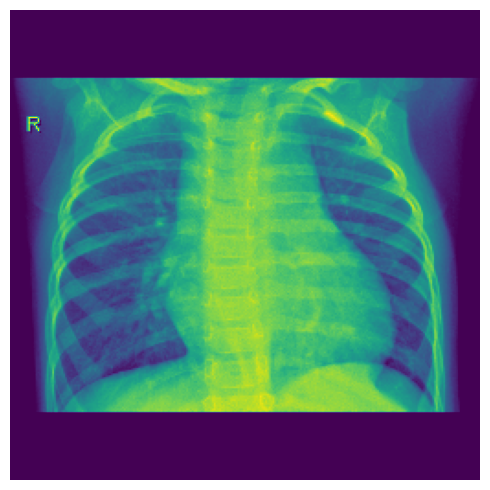

In [ ]:
print('Train Set')

plt.figure(figsize=(5,5))


plt.imshow(x_train[0])
plt.axis("off")

plt.tight_layout()

plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,
                                      test_size=0.1)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, BatchNormalization

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu', input_shape = (256, 256, 1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (6,6), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (6,6), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      1

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("drive/MyDrive/x-ray/conv2d.keras",
                             monitor="val_accuracy", save_best_only=True,
                             mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode='auto', verbose=1)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose=1, batch_size=32,
                   callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/12
236/236 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8951 
Epoch 1: val_accuracy improved from -inf to 0.86532, saving model to drive/MyDrive/x-ray/conv2d.keras
236/236 [==============================] - 2580s 11s/step - loss: 0.2846 - accuracy: 0.8951 - val_loss: 0.3082 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 2/12
236/236 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9337 
Epoch 2: val_accuracy improved from 0.86532 to 0.94398, saving model to drive/MyDrive/x-ray/conv2d.keras
236/236 [==============================] - 2582s 11s/step - loss: 0.1816 - accuracy: 0.9337 - val_loss: 0.1718 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 3/12
236/236 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9418 
Epoch 3: val_accuracy improved from 0.94398 to 0.94517, saving model to drive/MyDrive/x-ray/conv2d.keras
236/236 [==============================] - 2566s 11s/step - loss: 0.1645 - accuracy: 0.9418 - val_loss:

In [ ]:
model.save("drive/MyDrive/x-ray/conv2d_last.keras")

In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/x-ray/effnet.keras")

In [ ]:
pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test,pred.round()))

In [ ]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf

image_size = 256

uploaded = files.upload()

img_np = np.frombuffer(uploaded[fn], np.uint8)
uploaded_img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)

resized_image = cv2.resize(uploaded_img, (image_size, image_size))
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray_image)

In [13]:
import cv2
import os
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("drive/MyDrive/x-ray/effnet.keras")

predict_in = []
image_size = 256

img = cv2.imread(os.path.join("drive/MyDrive/x-ray/bad","1.jpg"))
img = cv2.resize(img,(image_size, image_size))
predict_in.append(img)
predict_in = np.array(predict_in)

prediction = model.predict(predict_in)

# ответ лежит в prediction[0][0]: 0 -- проблем нет, 1 -- проблемы есть

1/1 [==============================] - 5s 5s/step


In [14]:
print(prediction)

[[0.9999835]]
